In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from ultralytics import RTDETR

In [3]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [4]:
#model = YOLO("yolov9e.pt")
#model.track("train/task1/02_query.mp4", show=True, tracker="./trackers/bytetrack.yaml", conf=0.1, iou=0.1, agnostic_nms=True, augment=True, max_det=1000) 

In [5]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

query = load_video("train/task1/05_query.mp4")
reference = load_video("train/task1/05_reference.mp4")

In [6]:
query.do_tracking()
reference.do_tracking()

In [7]:
camera_query = query.get_camera()
camera_reference = reference.get_camera()

print("Query camera:", camera_query)
print("Reference camera:", camera_reference)

Query camera: B
Reference camera: A


In [8]:
F = homography_matrices[camera_query][camera_reference] 
print(F)
F_inv = homography_matrices[camera_reference][camera_query] 
print(F_inv)

[[  -0.069412     -2.8457      2033.8]
 [   -0.10792    -0.83212      548.92]
 [-0.00025251  -0.0014036           1]]
[[    0.26927     0.48259     -963.97]
 [   0.024674     -1.8897      759.28]
 [ 0.00014302  -0.0026006           1]]


In [9]:
# Find the frame with the most keypoints 

best_frame_index = 0
max_keypoints = 0

for i in range(query.num_frames()):
    frame = query.get_frame(i)
    keypoints = get_keypoints(frame, camera_query, camera_reference, F)

    if len(keypoints) > max_keypoints:
        max_keypoints = len(keypoints)
        best_frame_index = i
print("Best frame index:", best_frame_index, max_keypoints)

Best frame index: 38 4


In [69]:
query_index = 170 
reference_index = 470 

[{'position': (1018, 840), 'class': 'moving_object'}, {'position': (150, 758), 'class': 'moving_object'}, {'position': (793, 719), 'class': 'moving_object'}]
[{'position': (974, 1000), 'class': 'moving_object'}, {'position': (1102, 1000), 'class': 'moving_object'}, {'position': (1081, 961), 'class': 'moving_object'}, {'position': (1098, 946), 'class': 'moving_object'}, {'position': (1223, 869), 'class': 'moving_object'}, {'position': (1350, 1000), 'class': 'moving_object'}, {'position': (407, 647), 'class': 'moving_object'}, {'position': (862, 591), 'class': 'moving_object'}, {'position': (951, 586), 'class': 'moving_object'}, {'position': (852, 612), 'class': 'moving_object'}, {'position': (968, 599), 'class': 'moving_object'}, {'position': (374, 609), 'class': 'moving_object'}]


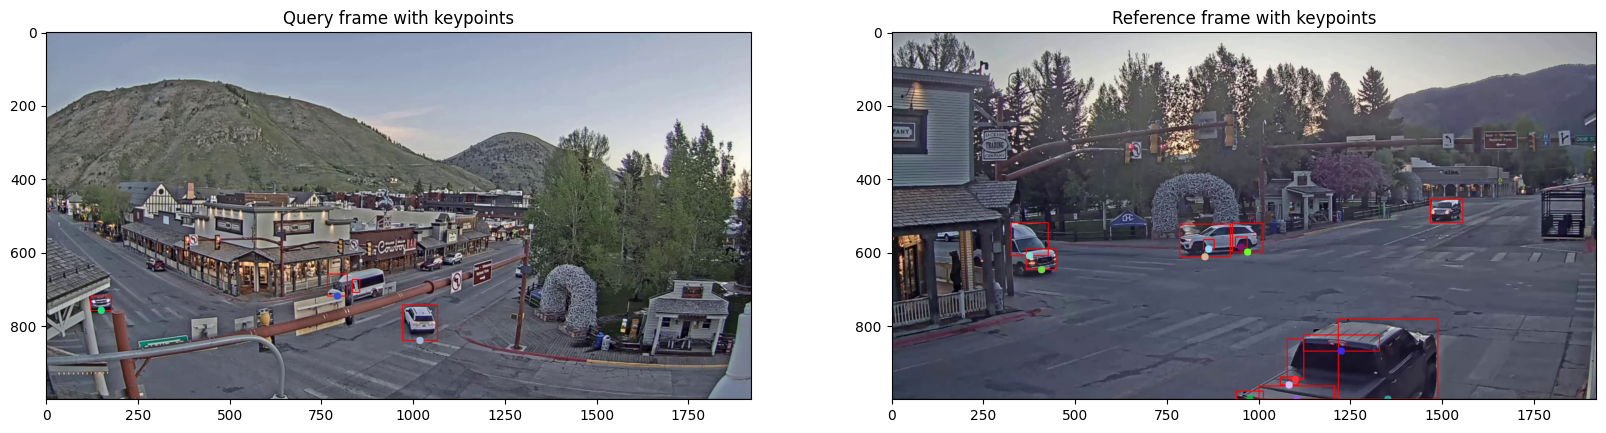

In [70]:
query_frame = query.get_frame(query_index)
query_frame_plot = query_frame.raw().copy()
reference_frame = reference.get_frame(reference_index)
reference_frame_plot = reference_frame.raw().copy()
colors = []

for object in query_frame.get_objects():
    x1, y1, x2, y2 = object["bbox"]
    cv.rectangle(query_frame_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

keypoints1 = get_keypoints(query_frame, camera_query, camera_reference, F)
print(keypoints1)
for keypoint in keypoints1:
    color = np.random.randint(0, 255, size=3).tolist()
    colors.append(color)
    cv.circle(query_frame_plot, keypoint["position"], 10, color, -1)

######################################################################
for object in reference_frame.get_objects():
    x1, y1, x2, y2 = object["bbox"]
    cv.rectangle(reference_frame_plot, (x1, y1), (x2, y2), (255, 0, 0), 2)

keypoints2 = get_keypoints(reference_frame, camera_reference, camera_query, F_inv)
print(keypoints2)

for keypoint in keypoints2:
    color = np.random.randint(0, 255, size=3).tolist()
    cv.circle(reference_frame_plot, keypoint["position"], 10, color, -1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Query frame with keypoints")
ax[0].imshow(query_frame_plot)
ax[1].set_title("Reference frame with keypoints")
ax[1].imshow(reference_frame_plot)
plt.show()

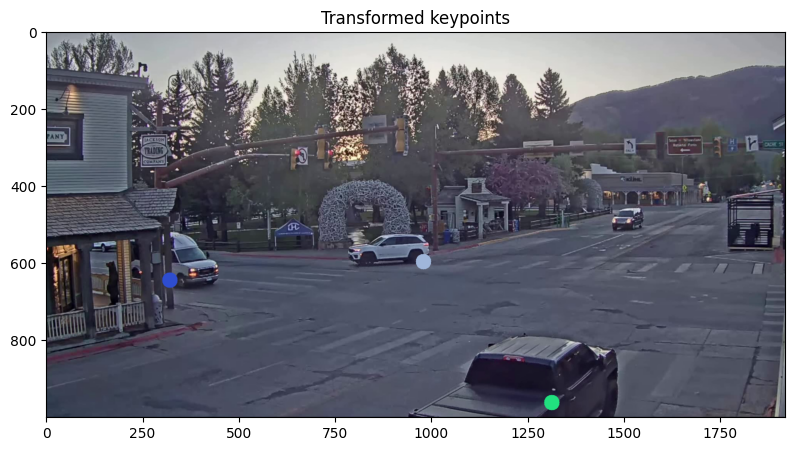

In [71]:
reference_frame = reference.get_frame(reference_index)
reference_frame_plot = reference_frame.raw().copy()

for i, keypoint in enumerate(keypoints1):
    pos1_tmp = np.array([[keypoint["position"]]]).astype(np.float32)
    transformed = cv.perspectiveTransform(pos1_tmp, F).squeeze().astype(np.int32)

    cv.circle(reference_frame_plot, transformed, 20, colors[i], -1)

plt.figure(figsize=(10, 5))
plt.title("Transformed keypoints")
plt.imshow(reference_frame_plot)
plt.show()

In [72]:
matching_query = query_frame.raw().copy()
matching_reference = reference_frame.raw().copy()

cost = get_assignment(keypoints1, keypoints2, F)
print(cost)


# for i in range(len(assignment[0])):
#     a = assignment[0][i]
#     b = assignment[1][i]

#     keypoint_a = keypoints1[a]["position"]
#     keypoint_b = keypoints2[b]["position"]
#     print(keypoint_a, keypoint_b)

#     color = np.random.randint(0, 255, size=3).tolist()

#     cv.circle(matching_query, keypoint_a, 20, color, -1)
#     cv.circle(matching_reference, keypoint_b, 20, color, -1)

# plt.figure(figsize=(10, 5))
# plt.imshow(matching_query)
# plt.show()
# plt.figure(figsize=(10, 5))
# plt.imshow(matching_reference)
# plt.show()

3


In [56]:
num_query_frames = query.num_frames()
num_reference_frames = reference.num_frames()
print(num_query_frames)
costs = []

min_cost = np.inf 
best_frame_pair = None

for i in range(0, num_reference_frames-num_query_frames+1):
    total_cost = 0
    num_nonempty_frames = 0

    for t in range(num_query_frames):
        frame_a = query.get_frame(t)
        frame_b = reference.get_frame(i + t)

        keypoints1 =  get_keypoints(frame_a, camera_query, camera_reference, F) 
        keypoints2 =  get_keypoints(frame_b, camera_reference, camera_query, F_inv) 

        cost = get_assignment(keypoints1, keypoints2, F) 
        total_cost += cost

    print(total_cost, num_nonempty_frames)

    costs.append(total_cost)
    print(f"Frame {i}: cost = {total_cost}")

181
0 0
Frame 0: cost = 0
0 0
Frame 1: cost = 0
0 0
Frame 2: cost = 0
0 0
Frame 3: cost = 0
0 0
Frame 4: cost = 0
0 0
Frame 5: cost = 0
0 0
Frame 6: cost = 0
0 0
Frame 7: cost = 0
0 0
Frame 8: cost = 0
0 0
Frame 9: cost = 0
0 0
Frame 10: cost = 0
0 0
Frame 11: cost = 0
0 0
Frame 12: cost = 0
0 0
Frame 13: cost = 0
0 0
Frame 14: cost = 0
0 0
Frame 15: cost = 0
0 0
Frame 16: cost = 0
0 0
Frame 17: cost = 0
0 0
Frame 18: cost = 0
0 0
Frame 19: cost = 0
0 0
Frame 20: cost = 0
0 0
Frame 21: cost = 0
0 0
Frame 22: cost = 0
0 0
Frame 23: cost = 0
0 0
Frame 24: cost = 0
0 0
Frame 25: cost = 0
0 0
Frame 26: cost = 0
0 0
Frame 27: cost = 0
0 0
Frame 28: cost = 0
0 0
Frame 29: cost = 0
0 0
Frame 30: cost = 0
0 0
Frame 31: cost = 0
0 0
Frame 32: cost = 0
0 0
Frame 33: cost = 0
0 0
Frame 34: cost = 0
0 0
Frame 35: cost = 0
0 0
Frame 36: cost = 0
0 0
Frame 37: cost = 0
0 0
Frame 38: cost = 0
0 0
Frame 39: cost = 0
0 0
Frame 40: cost = 0
0 0
Frame 41: cost = 0
0 0
Frame 42: cost = 0
0 0
Frame 43: cos

293
None


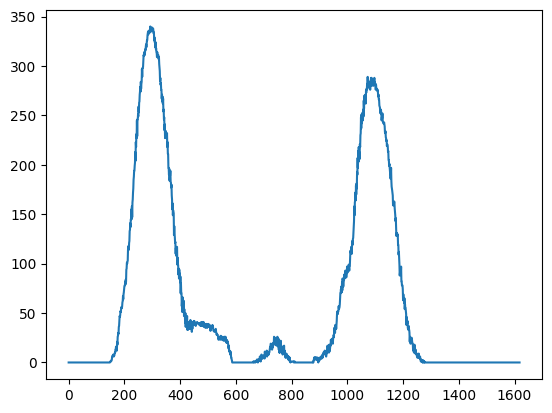

In [57]:
plt.plot(costs)
print(np.argmax(costs))
print(best_frame_pair)